In [1]:
from genesis.version4 import Genesis4, Write
import genesis.version4 as g4
from genesis import tools
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


from TaperFunctions import *   #import adiational functions

Genesis4.apply_taper = apply_taper

In [2]:
run_file_location=os.path.expandvars('$LCLS_LATTICE/genesis/version4/cu_hxr/')
run_file=os.path.expandvars('cu_hxr.in')
Lattice_file=os.path.expandvars('hxr.lat')
workdir=os.path.expandvars('$SCRATCH')

In [3]:
### Genesis4 looks for additional files in the workdir, not the file location.
## We can get around this by copying the beam current and gamma to scratch. 
## We get around this by copying these to scratch

import shutil


shutil.copy(run_file_location +'beam_current.h5' , workdir)

shutil.copy(run_file_location +'beam_gamma.h5' , workdir)

'/sdf/scratch/users/j/jmorgan/beam_gamma.h5'

In [4]:
def runGenesis(run_file_location, run_file,Lattice_file, workdir, nproc=2):


    file=run_file_location + run_file
    
    G = Genesis4(file, lattice= run_file_location + Lattice_file, workdir=workdir, verbose = True)


   # G.input.main.beam.alphax=1.0   #example in how to change the input file. 
    
    G.input.main.namelists.append(Write(field="end"))


    Kstart=1.7017
    taper=0.1
    nwig=130
    xlamdu=0.026
    ustart = 31
    ustop = 33
    l_und = 0.026

    G.apply_taper(Kstart = Kstart, dKbyK = taper, ustart = ustart, ustop = ustop, nwig =nwig, uperiod = xlamdu, order = 1)

    
    G.nproc = nproc  
    
    G.write_input(path=G.path, write_run_script=True)

  

    G.mpi_run='salloc --partition milano --account ad:beamphysics --mem-per-cpu=4g -n {nproc} mpirun -n {nproc} {command_mpi}'

    G.run()

    
    
    return G

In [5]:
G=runGenesis(run_file_location, run_file,Lattice_file, workdir, nproc=20)

apply taper  32
Configured to run in: /sdf/scratch/users/j/jmorgan/tmpqxlcdnp7
Setting use_mpi = True because nproc = 20
Running Genesis4 in /sdf/scratch/users/j/jmorgan/tmpqxlcdnp7
salloc --partition milano --account ad:beamphysics --mem-per-cpu=4g -n 20 mpirun -n 20 /sdf/home/j/jmorgan/conda/envs/Xopt/bin/genesis4 -l hxr.lat genesis4.in


salloc: Pending job allocation 55858475
salloc: job 55858475 queued and waiting for resources
salloc: job 55858475 has been allocated resources
salloc: Granted job allocation 55858475
salloc: Waiting for resource configuration
salloc: Nodes sdfmilan[114-115] are ready for job


---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by conda at 2024-06-10 16:25:29 [UTC] from Git Commit ID: 07004e4cb437003b4b6cf024122db18caee13722
Starting Time: Fri Sep 20 13:10:56 2024

MPI-Comm Size: 20 nodes

Opened input file genesis4.in
Parsing lattice file hxr.lat ...
Setting up time window of 15.444 microns with 560 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 560 slices for a time window of 15.444 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
  Calculation: 10% done
  Calculation: 20% done
  Calculation: 30% done
  Calculation: 40% done
  Calculation: 50% done
  Calculation: 60% done
  Calculation: 70% done
  Calculation: 80% done
  Calculation: 90% done
Calculation terminated due to requ

salloc: Relinquishing job allocation 55858475
salloc: Job allocation 55858475 has been revoked.


In [6]:
from scipy.constants import c, e, epsilon_0
import scipy
h = scipy.constants.value("Planck constant in eV/Hz")

def spectrum_from_field(field, dt=1):
    """
    Calculates the spectrum (fourier transformed field)
    from a complex field array with spacing dt.

    Parameters
    ----------
    field: nd.array of shape (n,)
        Complex field

    dt: float
        Spacing of the field data in some units (e.g. 's')

    Returns
    -------
    freqs: nd.array of shape (n,)
        Frequencies in reciprocal space with inverse units (e.g. 'Hz = 1/s')

    spectrum: nd.array of shape (n,)
        The fourier transformed field

    """
    if len(field.shape) != 1:
        raise ValueError("Only 1D arrays are currently supported")
    spectrum = np.fft.fftshift(np.fft.fft(field)) * dt

    ns = len(field)
    freqs = np.fft.fftshift(np.fft.fftfreq(ns, dt))

    return freqs, spectrum


def plotspectrum(G):
    """
    This function is based on the example on github
    
    Parameters:
    G (Genesis object): The Genesis object containing simulation output data.
    
    Returns:
    peak_fluence (float): The maximum spectral fluence.
    peak_energy (float): The photon energy at the peak spectral fluence.
    fwhm_bandwidth (float): The Full Width at Half Maximum (FWHM) of the spectrum in eV.
    """
    G.output.load_fields()
    # Extract parameters from Genesis output
    param = G.output.field3d["end"].param
    Ns = param.slicecount
    ds = param.slicespacing
    λ0 = param.wavelength
    f0 = c / λ0
    dt = ds / c
    Δ = param.gridsize

    field = G.output.field
    intensity0 = field.intensity_nearfield[-1, :]  # W/m^2
    phase0 = field.phase_nearfield[-1, :]  # radian


    field0 = np.sqrt(intensity0) * np.exp(1j * phase0) * Δ
    
    # Frequency and spectrum calculation
    freqs, spectrum = spectrum_from_field(field0, dt)
    
    # Convert to photon energies (eV) and compute spectral fluence (J/m^2/eV)
    photon_energies = h * (freqs + f0)  # eV
    spectral_fluence = np.abs(spectrum**2) / Δ**2 / h  # J/m^2/eV


    fig, ax = plt.subplots()
    ax.plot(photon_energies, spectral_fluence)
    ax.set_xlabel("photon energy (eV)")  
    ax.set_ylabel(r"spectral fluence (J/m$^2$/eV)")
    


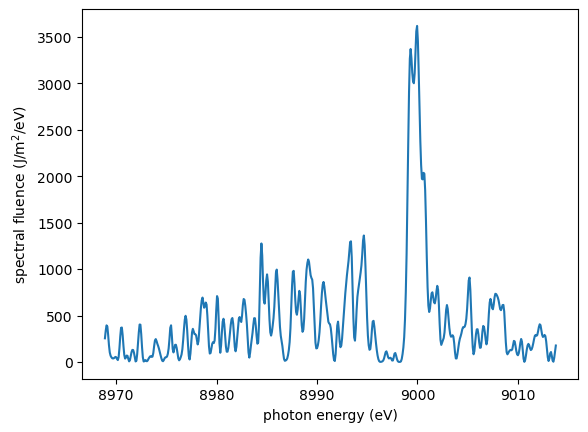

In [7]:
plotspectrum(G)